In [1]:
import sys
sys.path.append("../")
import pandas as pd
import numpy as np
from dateutil.parser import parse
from sklearn import metrics
import datetime

import model_ml as mm
import feat_engineering as fe
import feat_selection as fs
from param_config import config

In [6]:
dfTrain = pd.read_csv(config.original_train_data_path)
dfPred = pd.read_csv(config.original_pred_data_path)
predictors = dfPred.columns.tolist()[1:]

###清理异常Y值
dfTrain = dfTrain.loc[dfTrain['Y']<dfTrain['Y'].max()]
dfTrain = dfTrain.reset_index(drop=True)

In [7]:
fillna_RF(dfTrain,predictors,recurrent = False,seed = 202)

NameError: name 'fillna_RF' is not defined

In [9]:
def FeatAll(train,pred):
    dfAll = pd.concat([train,pred])
    '''for i in range(3,len(predictors)-1):
        for j in range(i+1,len(predictors)):
            dfAll[predictors[j]+'_minus_'+predictors[i]] = dfAll[predictors[j]] - dfAll[predictors[i]]
            dfAll[predictors[j]+'_divided_'+predictors[i]] = dfAll[predictors[j]]/dfAll[predictors[i]]'''
    dfAll['date'] = (pd.to_datetime(dfAll['date']) - parse('2017-10-09')).dt.days
    #dfPcent = fe.pcent_single_col(dfAll,predictors)
    
    '''dfAll['age'] = pd.qcut(dfAll['age'],q=10,labels=['age_bin_%d'%i for i in range(10)])
    dfAll = pd.concat([dfAll,pd.get_dummies(dfAll['age'])],axis=1)
    del dfAll['age']'''
    dfAll['date'] = pd.qcut(dfAll['date'],q=10,labels=['date_bin_%d'%i for i in range(10)])
    dfAll = pd.concat([dfAll,pd.get_dummies(dfAll['date'])],axis=1)
    del dfAll['date']
    #dfAll = pd.concat([dfAll,dfPcent],axis=1)
    
    for ratio in [['PartI_6','PartI_5'],['PartI_7','PartI_5'],['PartII_3','PartII_2'],['PartII_4','PartII_2']]:
        dfAll[ratio[0]+'_divided_'+ratio[1]] = dfAll[ratio[0]]/dfAll[ratio[1]]
        
    for key,group in {'PartI':['PartI_1','PartI_2','PartI_3','PartI_4'],'PartII':['PartII_1','PartII_3','PartII_4']}.items():
        dfAll['group_'+key+'_std'] = dfAll[group].std(axis=1)
        dfAll['group_'+key+'_mean'] = dfAll[group].mean(axis=1)
        dfAll['group_'+key+'_median'] = dfAll[group].median(axis=1)
    
    
    dfTrain = dfAll.loc[dfAll['ID'].isin(train['ID'])]
    dfPred = dfAll.loc[dfAll['ID'].isin(pred['ID'])]
    
    return dfTrain,dfPred
    

In [10]:
dfTrain,dfPred = FeatAll(dfTrain,dfPred)
predictors = dfPred.columns.tolist()
predictors.remove('ID')
predictors.remove('Y')

In [5]:
#predictors_pear = fs.Pearson_selection(dfTrain,predictors)
predictors_rf = fs.RF_selection(dfTrain,predictors)

0


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

ID                           5732.000000
PartIII_1                      13.390000
PartIII_2                     177.420000
PartIII_3                     774.060000
PartII_1                       41.570000
PartII_2                       20.460000
PartII_3                        5.280000
PartII_4                        8.460000
PartIV_1                       44.350000
PartIV_2                       42.490000
PartIV_3                       17.520000
PartIV_4                        7.170000
PartIV_5                       17.090000
PartI_1                       434.950000
PartI_2                       498.890000
PartI_3                       374.320000
PartI_4                       736.990000
PartI_5                       100.410000
PartI_6                        54.080000
PartI_7                        66.180000
PartI_8                         7.120000
PartVI_1                      745.000000
PartVI_2                       15.200000
PartVI_3                       25.300000
PartVI_4        

In [ ]:
predictors = fs.feat_combination([predictors_pear],400)

In [11]:
###将训练集按照Y值拆分成两个部分
highBound = 0.8
highTrain = dfTrain.loc[dfTrain['Y']>=dfTrain['Y'].quantile(highBound)]
lowTrain = dfTrain.loc[dfTrain['Y']<dfTrain['Y'].quantile(highBound)]

highPred = pd.concat([dfPred,lowTrain])
lowPred = pd.concat([dfPred,highTrain])

highTrain.reset_index(inplace=True)
lowTrain.reset_index(inplace=True)
highPred.reset_index(inplace=True)
lowPred.reset_index(inplace=True)

[0]	train-rmse:7.44772	eval-rmse:7.18824
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.


..\model_ml.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfTrain['wgt'] = 1


[100]	train-rmse:3.30241	eval-rmse:3.16103
[200]	train-rmse:2.02045	eval-rmse:2.08295
[300]	train-rmse:1.63947	eval-rmse:1.88866
[400]	train-rmse:1.46828	eval-rmse:1.85252
Stopping. Best iteration:
[434]	train-rmse:1.42738	eval-rmse:1.84252

Best tree is 435, performance is 1.427375, 1.842516


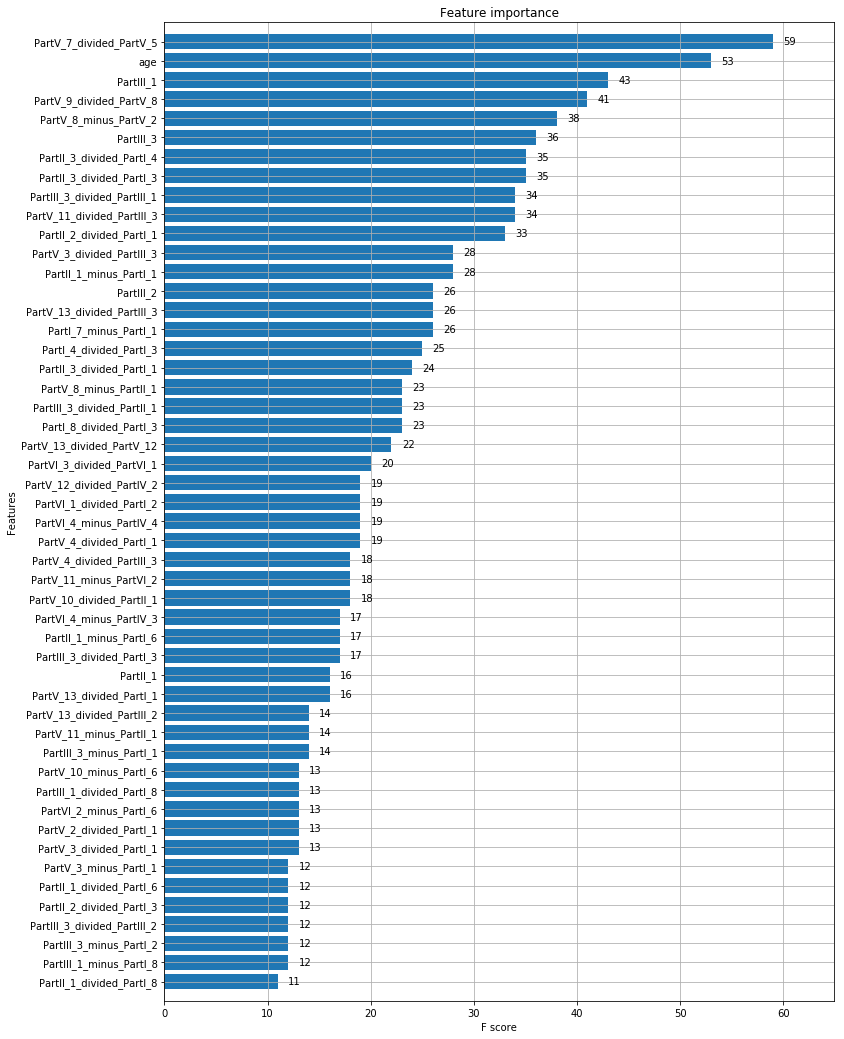

[0]	train-rmse:7.33736	eval-rmse:7.62927
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[100]	train-rmse:3.21698	eval-rmse:3.77443
[200]	train-rmse:1.93079	eval-rmse:2.77179
[300]	train-rmse:1.54039	eval-rmse:2.57135
[400]	train-rmse:1.3712	eval-rmse:2.5311
Stopping. Best iteration:
[462]	train-rmse:1.30132	eval-rmse:2.5213

Best tree is 463, performance is 1.301316, 2.521300


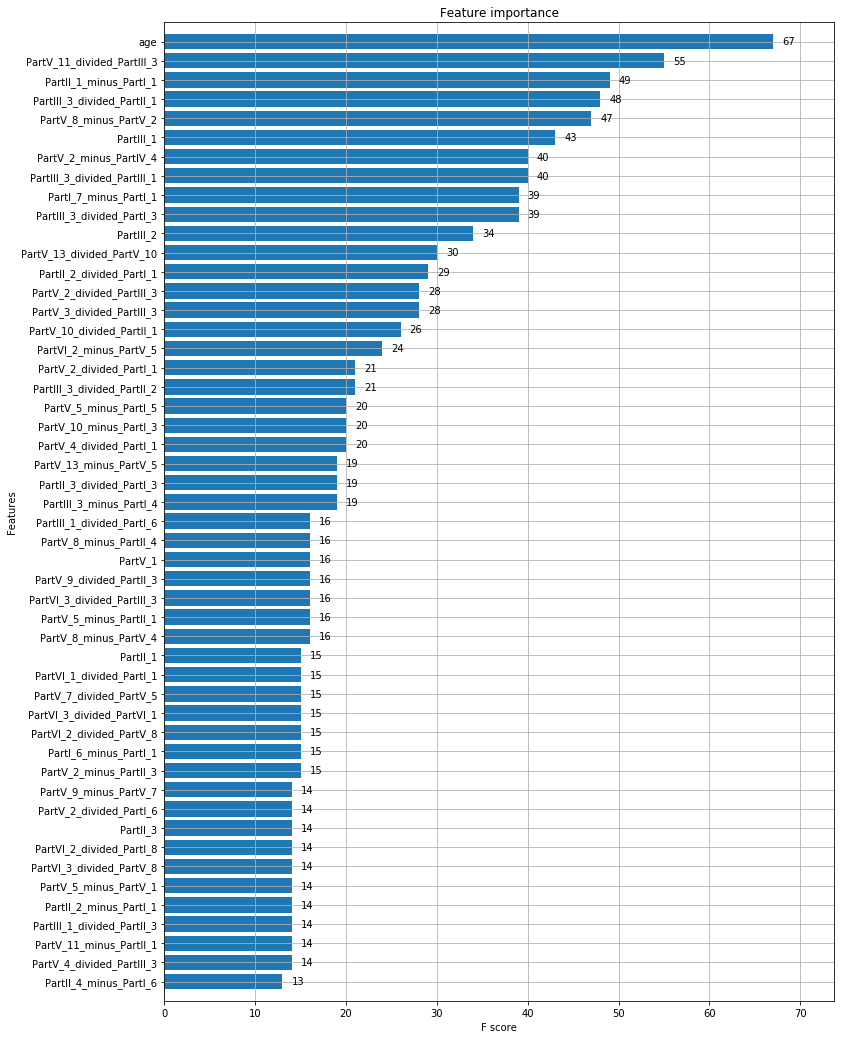

[0]	train-rmse:7.32993	eval-rmse:7.65798
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[100]	train-rmse:3.21366	eval-rmse:3.74922
[200]	train-rmse:1.93647	eval-rmse:2.70239
[300]	train-rmse:1.55952	eval-rmse:2.48031
[400]	train-rmse:1.39949	eval-rmse:2.43113
[500]	train-rmse:1.28738	eval-rmse:2.41015
Stopping. Best iteration:
[499]	train-rmse:1.28835	eval-rmse:2.40978

Best tree is 500, performance is 1.288347, 2.409781


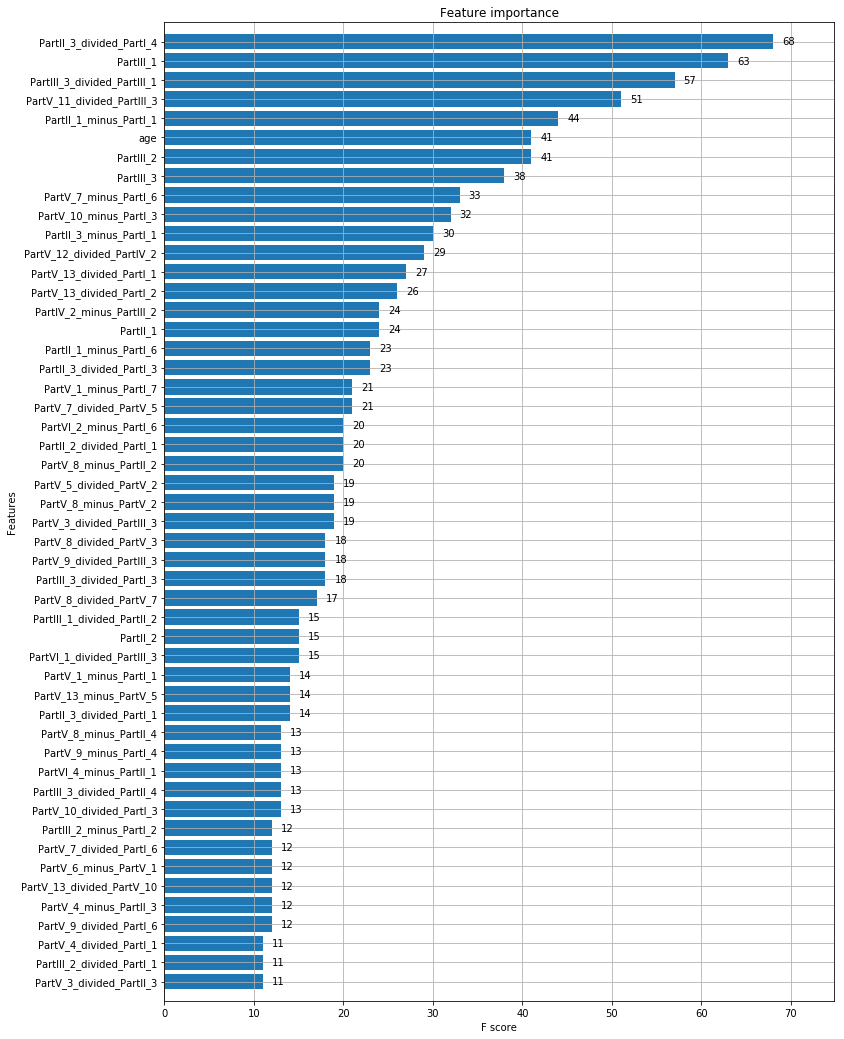

[0]	train-rmse:7.43985	eval-rmse:7.21552
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[100]	train-rmse:3.2932	eval-rmse:3.19473
[200]	train-rmse:2.02061	eval-rmse:2.17293
[300]	train-rmse:1.63595	eval-rmse:2.02673
Stopping. Best iteration:
[313]	train-rmse:1.60859	eval-rmse:2.02408

Best tree is 314, performance is 1.608594, 2.024076


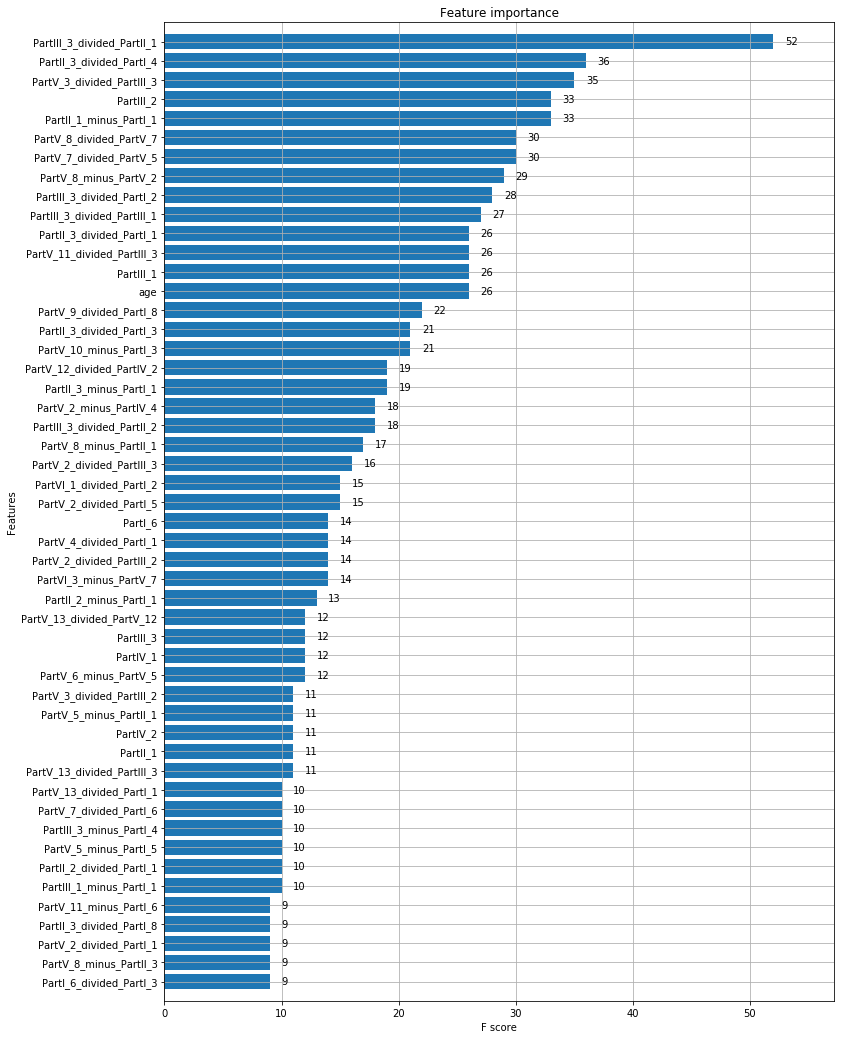

[0]	train-rmse:7.42351	eval-rmse:7.28149
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[100]	train-rmse:3.28168	eval-rmse:3.2685
[200]	train-rmse:2.00771	eval-rmse:2.22798
[300]	train-rmse:1.63514	eval-rmse:2.0467
Stopping. Best iteration:
[378]	train-rmse:1.49922	eval-rmse:2.03021

Best tree is 379, performance is 1.499219, 2.030210


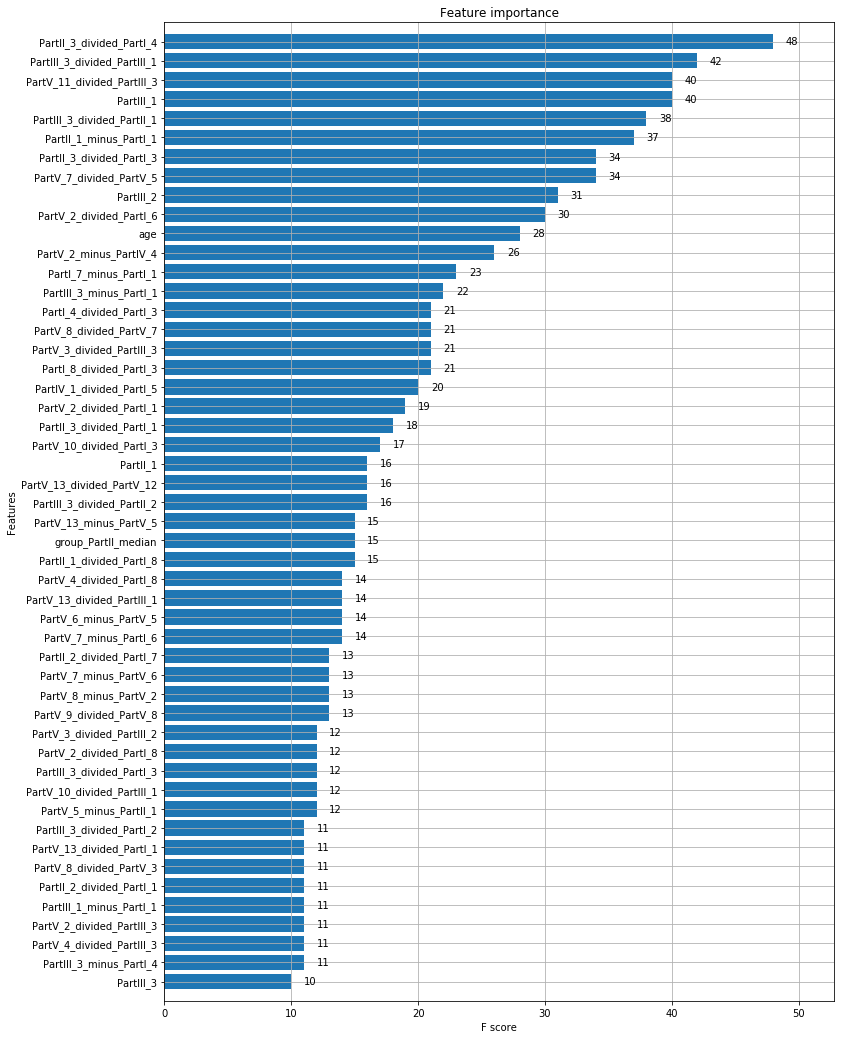

Test MSE: 4.75429741264
[0]	train-rmse:4.60807	eval-rmse:4.59732
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[100]	train-rmse:1.72907	eval-rmse:1.72095
[200]	train-rmse:0.726529	eval-rmse:0.727829
[300]	train-rmse:0.435106	eval-rmse:0.452675
[400]	train-rmse:0.371375	eval-rmse:0.40231
[500]	train-rmse:0.354884	eval-rmse:0.396043
[600]	train-rmse:0.346438	eval-rmse:0.395204
Stopping. Best iteration:
[606]	train-rmse:0.346024	eval-rmse:0.395157

Best tree is 607, performance is 0.346024, 0.395157


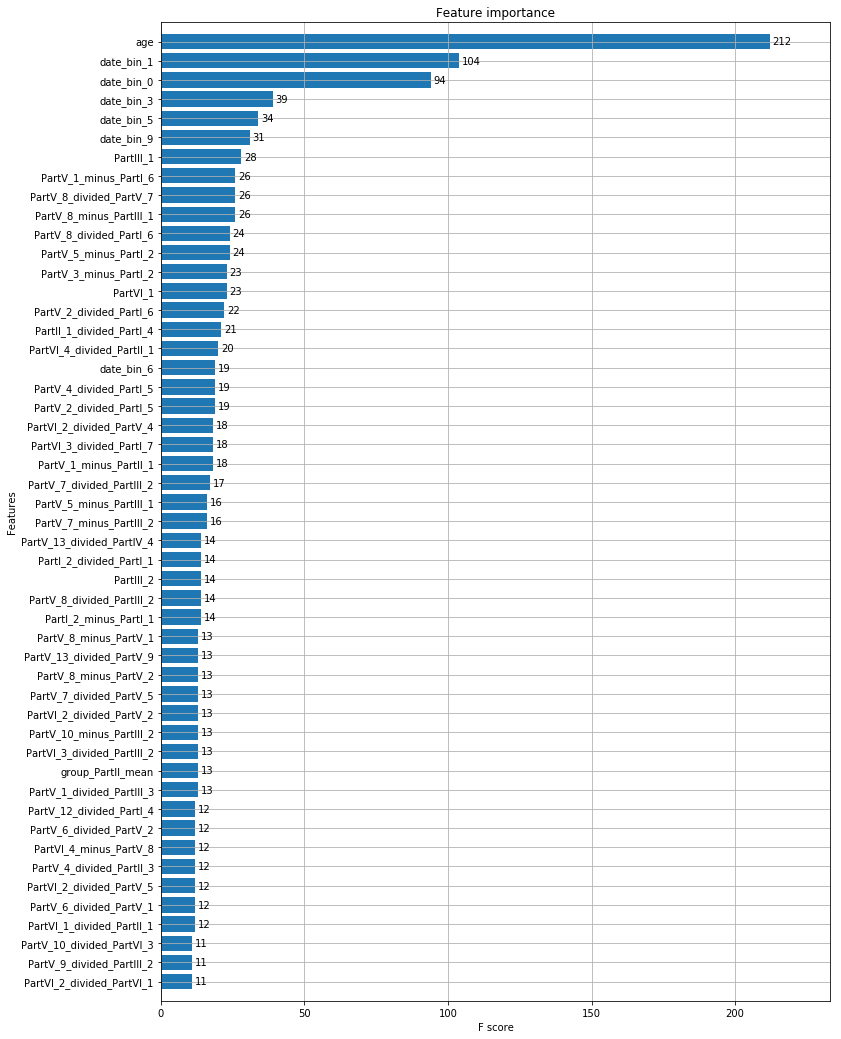

[0]	train-rmse:4.60407	eval-rmse:4.61376
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[100]	train-rmse:1.72725	eval-rmse:1.7376
[200]	train-rmse:0.72553	eval-rmse:0.741879
[300]	train-rmse:0.434177	eval-rmse:0.461255
[400]	train-rmse:0.370491	eval-rmse:0.40632
[500]	train-rmse:0.354727	eval-rmse:0.396737
[600]	train-rmse:0.346679	eval-rmse:0.39483
Stopping. Best iteration:
[617]	train-rmse:0.345437	eval-rmse:0.394657

Best tree is 618, performance is 0.345437, 0.394657


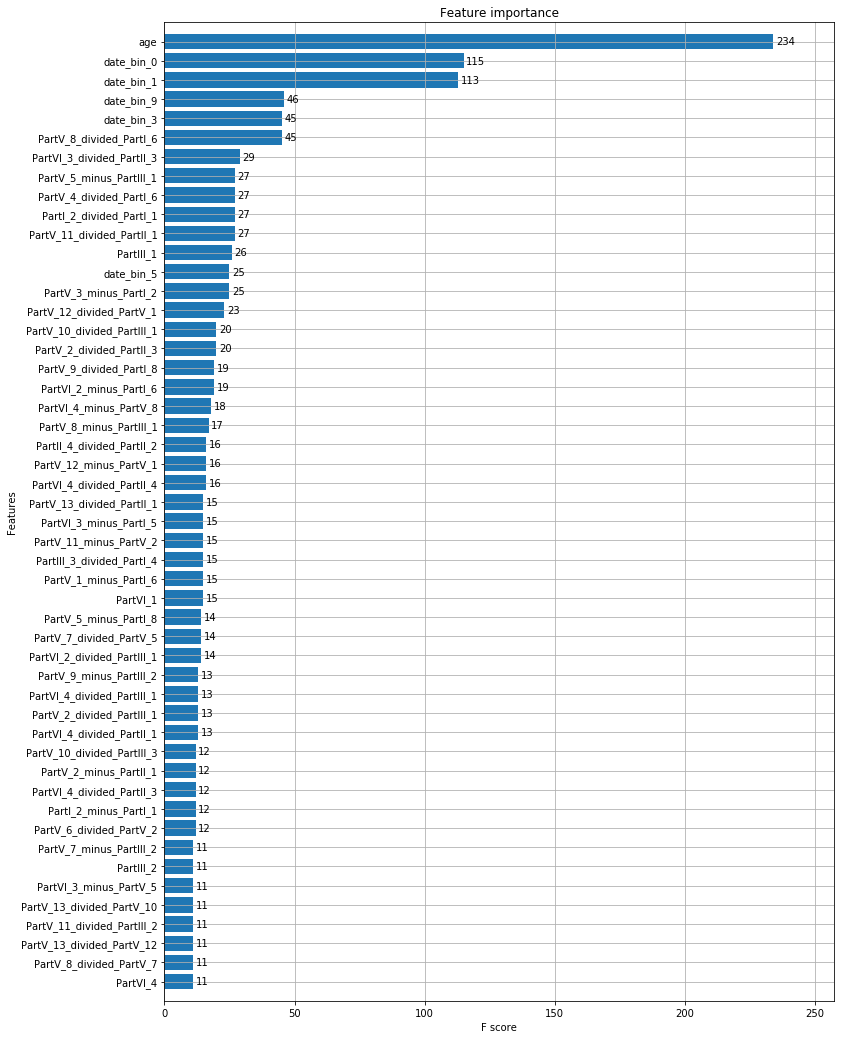

[0]	train-rmse:4.60698	eval-rmse:4.60196
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[100]	train-rmse:1.72815	eval-rmse:1.72649
[200]	train-rmse:0.725454	eval-rmse:0.733624
[300]	train-rmse:0.433992	eval-rmse:0.457895
[400]	train-rmse:0.369984	eval-rmse:0.406427
[500]	train-rmse:0.353972	eval-rmse:0.398668
[600]	train-rmse:0.345819	eval-rmse:0.397396
Stopping. Best iteration:
[636]	train-rmse:0.34328	eval-rmse:0.396976

Best tree is 637, performance is 0.343280, 0.396976


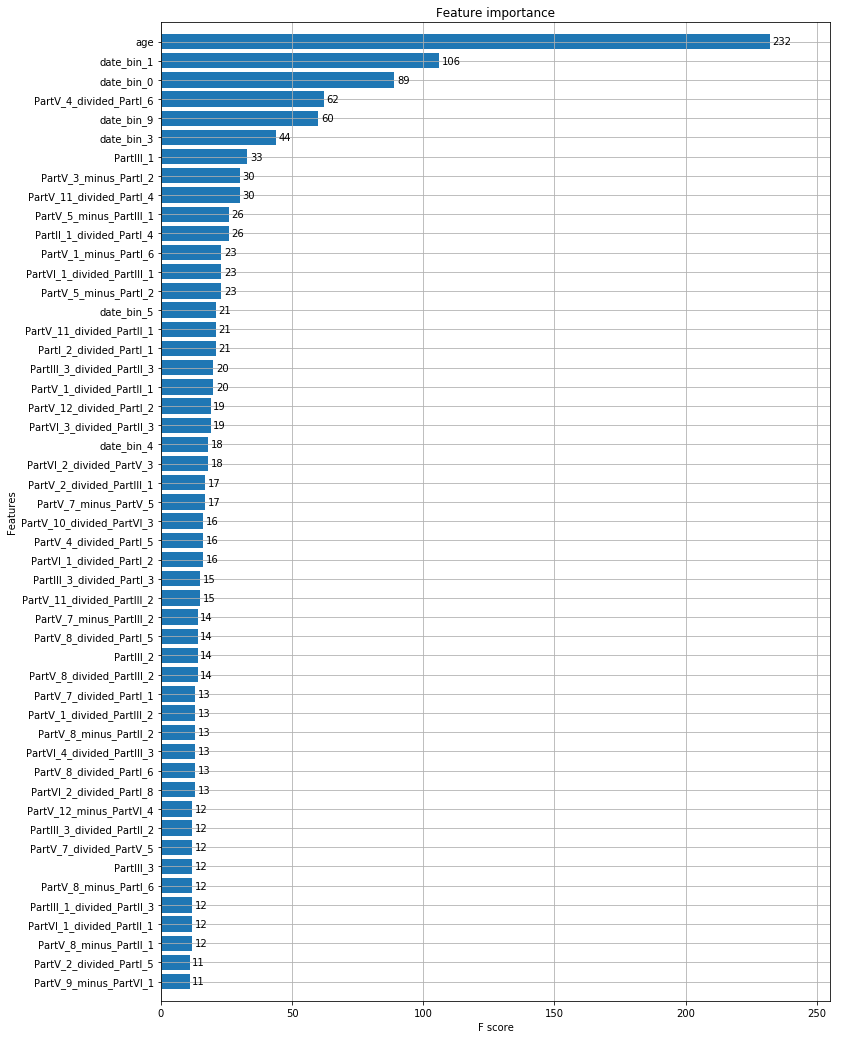

[0]	train-rmse:4.6075	eval-rmse:4.6
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[100]	train-rmse:1.72868	eval-rmse:1.72326
[200]	train-rmse:0.726676	eval-rmse:0.728483
[300]	train-rmse:0.435698	eval-rmse:0.449515
[400]	train-rmse:0.37243	eval-rmse:0.396548
[500]	train-rmse:0.356673	eval-rmse:0.388309
[600]	train-rmse:0.348434	eval-rmse:0.3867
Stopping. Best iteration:
[641]	train-rmse:0.345619	eval-rmse:0.386244

Best tree is 642, performance is 0.345619, 0.386244


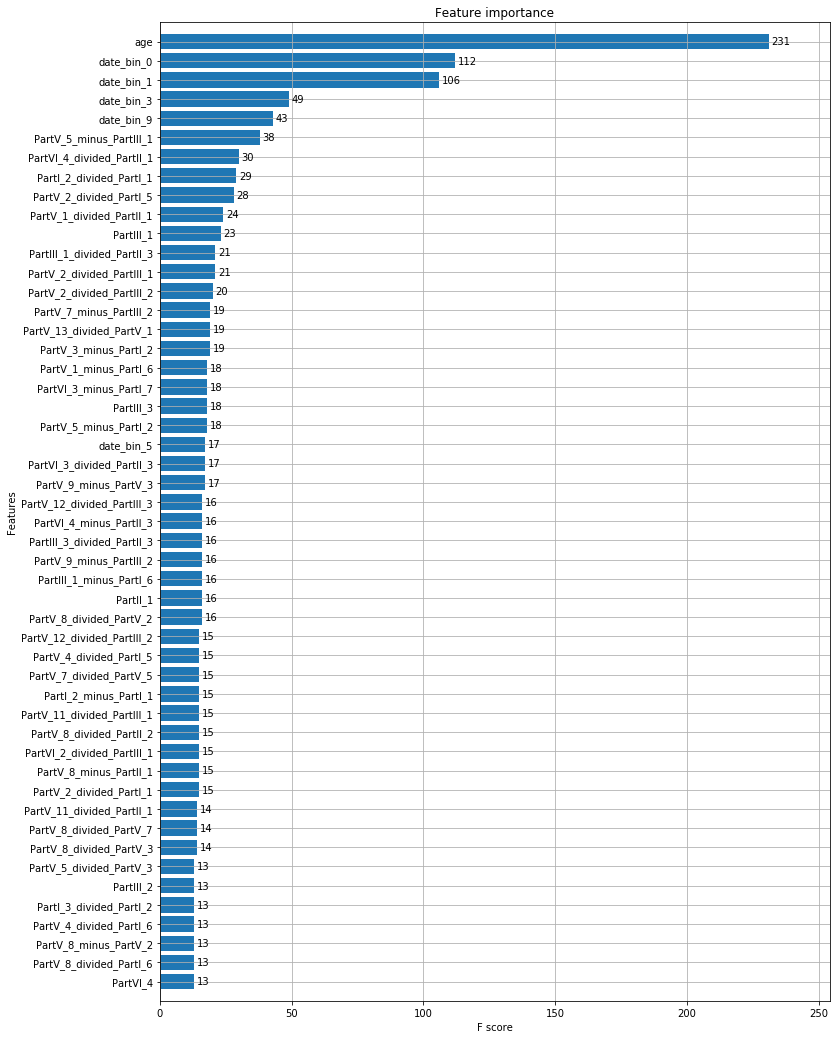

[0]	train-rmse:4.6033	eval-rmse:4.61684
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[100]	train-rmse:1.72767	eval-rmse:1.74138
[200]	train-rmse:0.726621	eval-rmse:0.742083
[300]	train-rmse:0.436254	eval-rmse:0.455566
[400]	train-rmse:0.373115	eval-rmse:0.397501
[500]	train-rmse:0.357266	eval-rmse:0.387112
[600]	train-rmse:0.349009	eval-rmse:0.385214
Stopping. Best iteration:
[665]	train-rmse:0.344696	eval-rmse:0.384661

Best tree is 666, performance is 0.344696, 0.384661


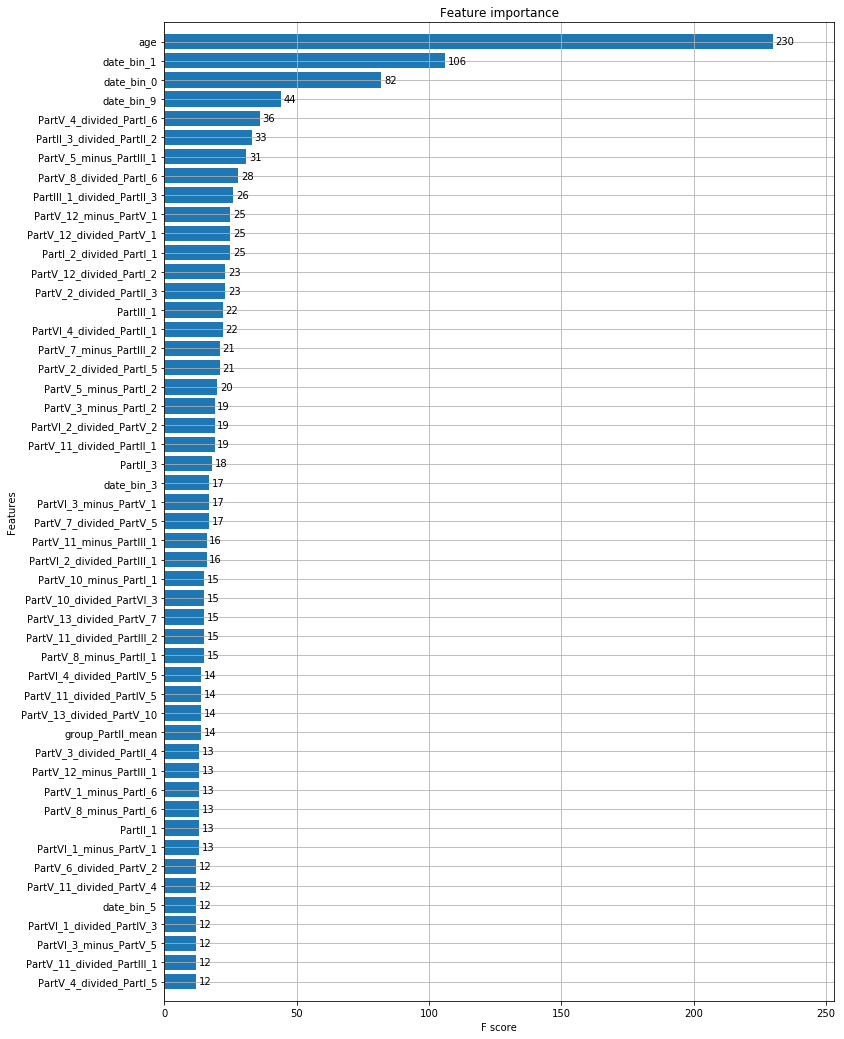

Test MSE: 0.153328350987


In [12]:
n_splits=5
high_test,high_result,high_imp = mm.xgb_kfold(highTrain,highPred,predictors)
low_test,low_result,low_imp = mm.xgb_kfold(lowTrain,lowPred,predictors)

In [13]:
###将两类血糖状态合并
high_result['high_score']=high_result[['Score_%d'%i for i in range(1,n_splits+1)]].mean(axis=1)
low_result['low_score']=low_result[['Score_%d'%i for i in range(1,n_splits+1)]].mean(axis=1)
high_result.sort_values('ID',ascending=True,inplace=True)
low_result.sort_values('ID',ascending=True,inplace=True)
high_result.set_index(high_result['ID'],inplace=True)
low_result.set_index(low_result['ID'],inplace=True)

high_test.rename(columns={'score':'high_score'},inplace=True)
low_test.rename(columns={'score':'low_score'},inplace=True)

test = pd.concat([high_test,low_test])
test.sort_values('ID',ascending=True,inplace=True)
test.set_index(test['ID'],inplace=True)

test.loc[test['high_score'].isnull(),'high_score'] = high_result.loc[high_result['ID'].isin(test['ID']),'high_score']
test.loc[test['low_score'].isnull(),'low_score'] = low_result.loc[low_result['ID'].isin(test['ID']),'low_score']
                                                                  
result = pd.merge(high_result.loc[~high_result['ID'].isin(test['ID']),['ID','high_score']],low_result.loc[~low_result['ID'].isin(test['ID']),['ID','low_score']],'inner','ID')


In [14]:
dfTrain_bin = dfTrain.copy()
dfTrain_bin['bin'] = 0
dfTrain_bin.loc[dfTrain_bin['Y']>=dfTrain_bin['Y'].quantile(highBound),'bin']=1
dfTrain_bin['Y'] = dfTrain_bin['bin']
del dfTrain_bin['bin']

[0]	train-logloss:0.688664	eval-logloss:0.689029
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[100]	train-logloss:0.469927	eval-logloss:0.494906
[200]	train-logloss:0.409194	eval-logloss:0.449576
[300]	train-logloss:0.382615	eval-logloss:0.436151
[400]	train-logloss:0.365062	eval-logloss:0.431396
[500]	train-logloss:0.350521	eval-logloss:0.430024
Stopping. Best iteration:
[530]	train-logloss:0.346533	eval-logloss:0.429768

Best tree is 531, performance is 0.346533, 0.429768


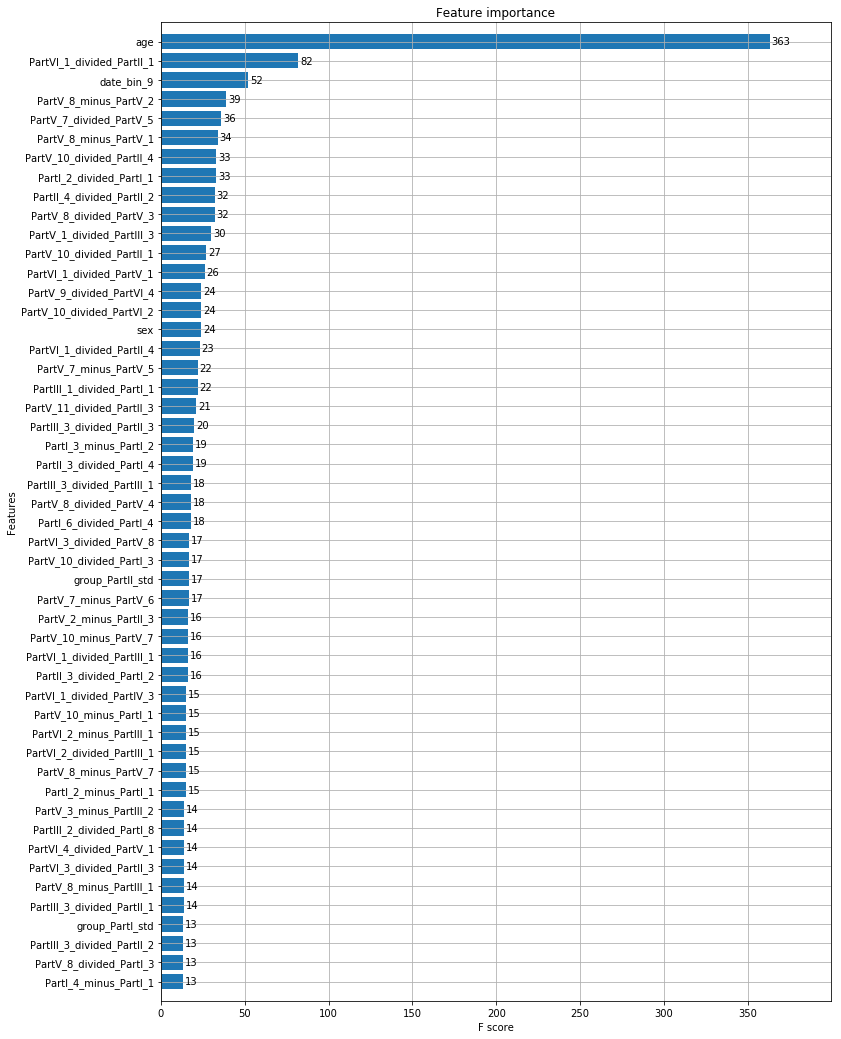

[0]	train-logloss:0.68882	eval-logloss:0.688704
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[100]	train-logloss:0.475531	eval-logloss:0.478396
[200]	train-logloss:0.415126	eval-logloss:0.42719
[300]	train-logloss:0.388787	eval-logloss:0.411964
[400]	train-logloss:0.371401	eval-logloss:0.405622
[500]	train-logloss:0.357024	eval-logloss:0.403057
Stopping. Best iteration:
[493]	train-logloss:0.357926	eval-logloss:0.403021

Best tree is 494, performance is 0.357926, 0.403021


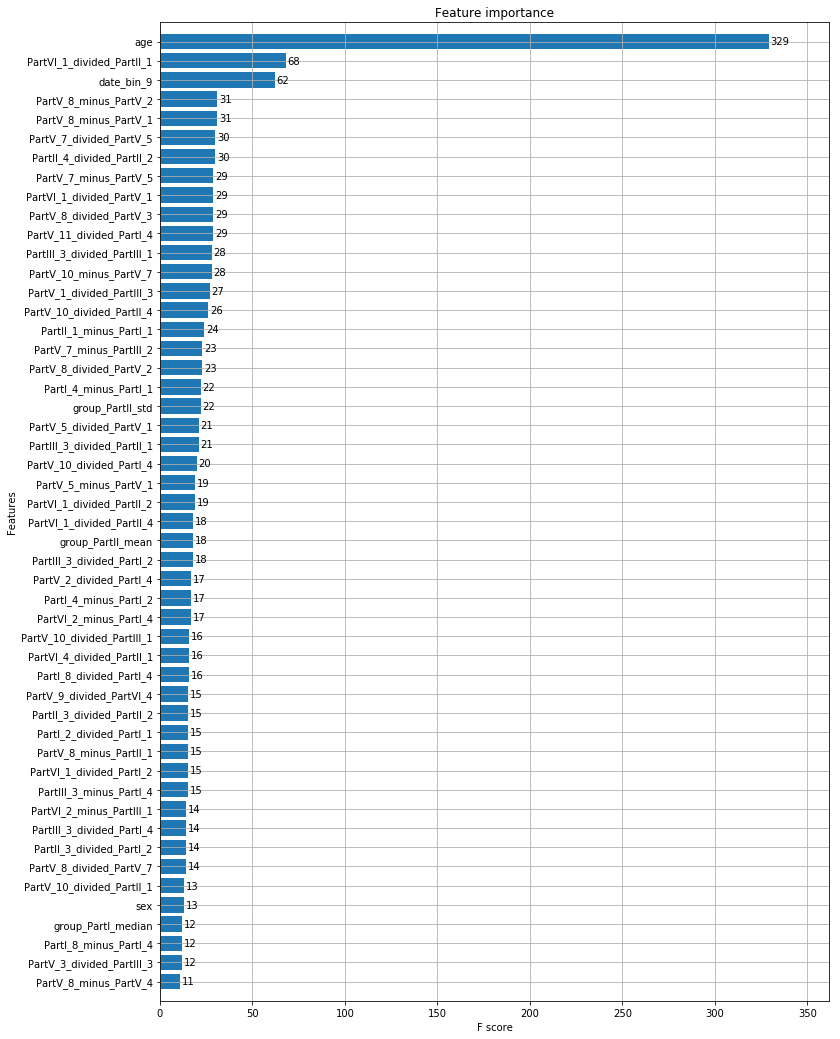

[0]	train-logloss:0.688696	eval-logloss:0.688857
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[100]	train-logloss:0.471916	eval-logloss:0.48908
[200]	train-logloss:0.411279	eval-logloss:0.440509
[300]	train-logloss:0.384565	eval-logloss:0.424759
[400]	train-logloss:0.367162	eval-logloss:0.418622
[500]	train-logloss:0.353108	eval-logloss:0.415636
Stopping. Best iteration:
[515]	train-logloss:0.351267	eval-logloss:0.415298

Best tree is 516, performance is 0.351267, 0.415298


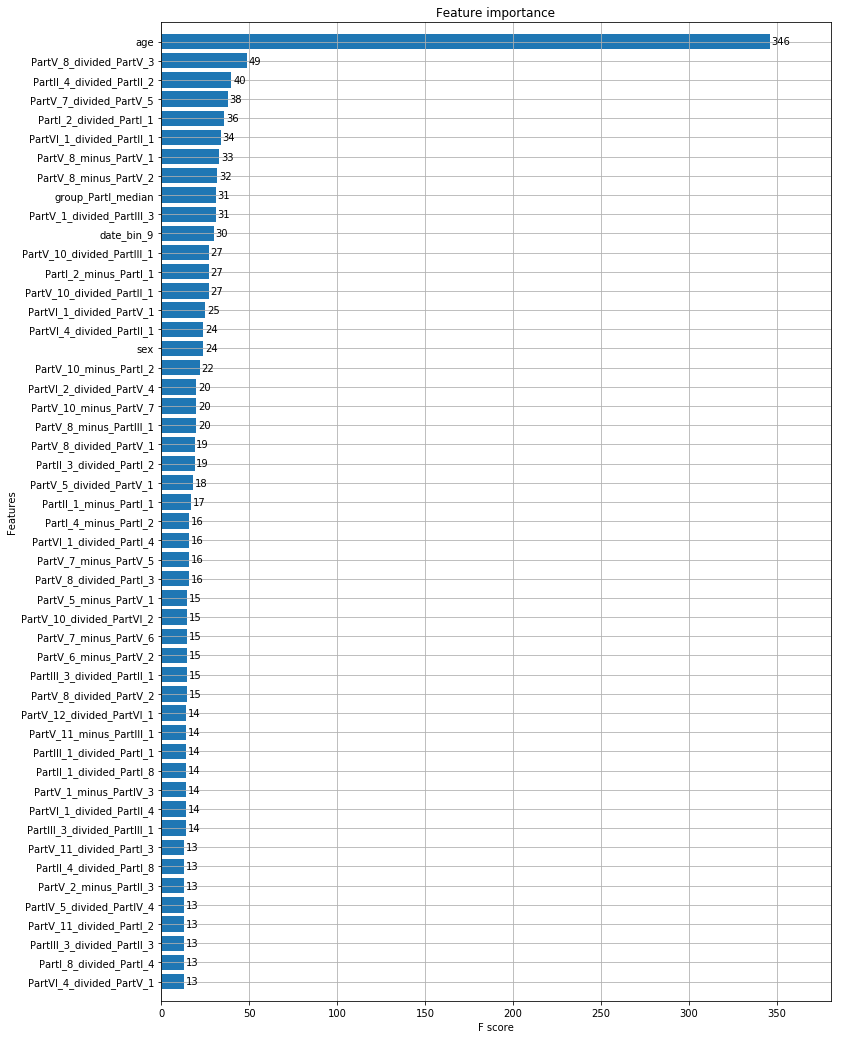

[0]	train-logloss:0.688627	eval-logloss:0.689018
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[100]	train-logloss:0.470929	eval-logloss:0.492043
[200]	train-logloss:0.409413	eval-logloss:0.447964
[300]	train-logloss:0.381981	eval-logloss:0.435257
[400]	train-logloss:0.36445	eval-logloss:0.43014
Stopping. Best iteration:
[403]	train-logloss:0.364078	eval-logloss:0.430083

Best tree is 404, performance is 0.364078, 0.430083


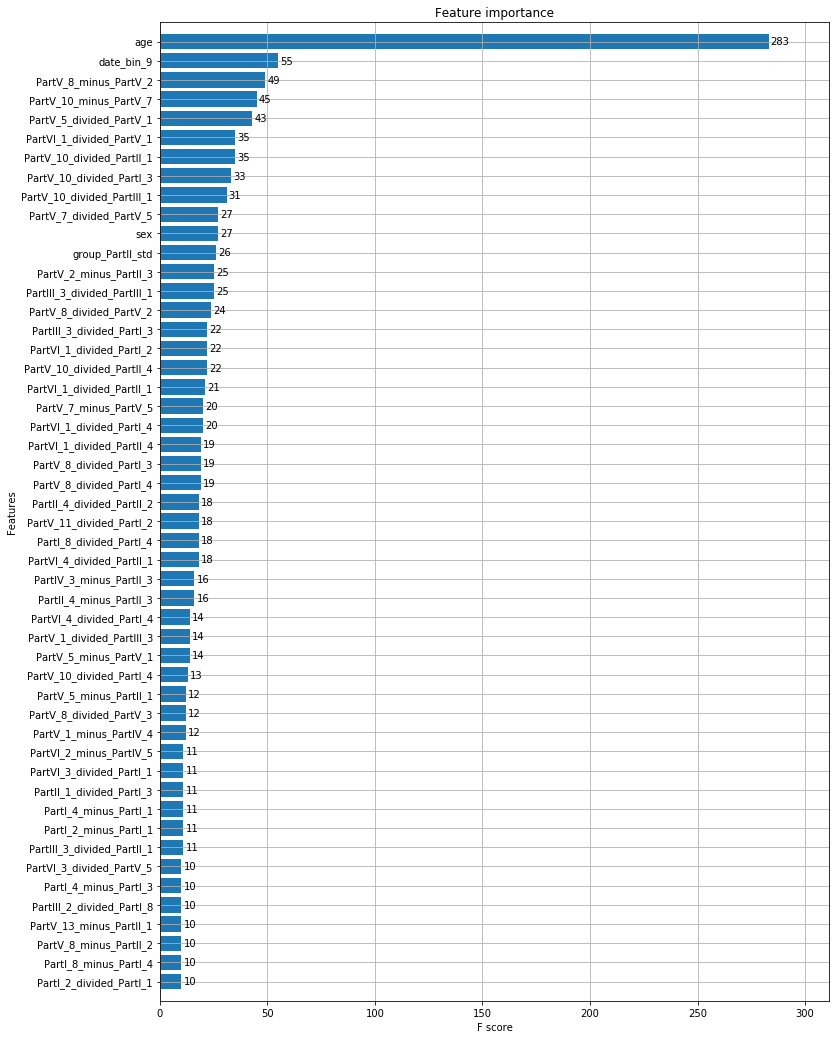

[0]	train-logloss:0.688677	eval-logloss:0.688909
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[100]	train-logloss:0.471958	eval-logloss:0.48864
[200]	train-logloss:0.410881	eval-logloss:0.441462
[300]	train-logloss:0.383681	eval-logloss:0.428067
[400]	train-logloss:0.365772	eval-logloss:0.424524
Stopping. Best iteration:
[439]	train-logloss:0.359968	eval-logloss:0.423794

Best tree is 440, performance is 0.359968, 0.423794


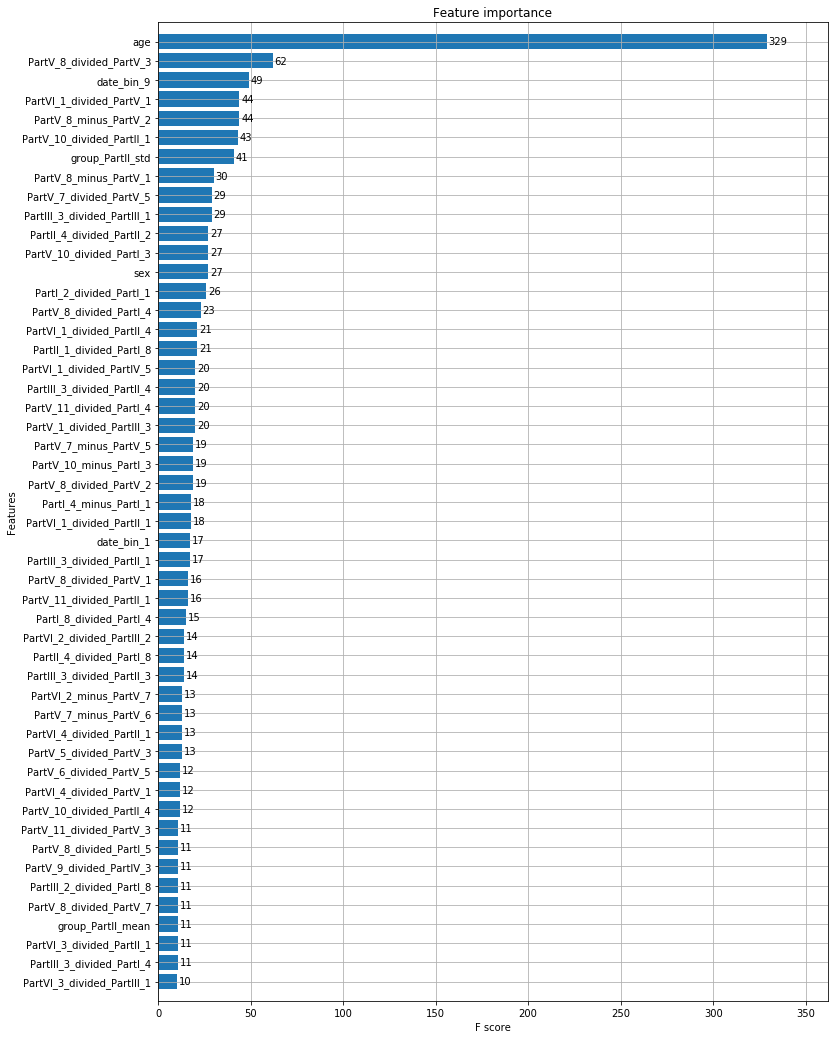

Test MSE: 0.133675796599


In [15]:
params = {'max_depth':3, 'eta':0.01, 'silent':0,'objective':'binary:logistic','lambda':1,'subsample':0.8,'colsample_bytree':0.8,'eval_metric':'logloss'}
test_result_bin,result_bin,imp = mm.xgb_kfold(dfTrain_bin,dfPred,predictors,params=params,metric_decrease=True)

In [ ]:
bstf1 = 0
for i in range(10,50):
    criteria = float(i)/100
    test_result_bin['score_bin'] = 1
    test_result_bin.loc[test_result_bin['score']<criteria,'score_bin']=0
    tmp = test_result_bin.groupby(['score_bin','target'])['ID'].count().unstack(level=1)
    pre =float(tmp.loc[1,1])/(tmp.loc[1,1]+tmp.loc[0,1])
    rec = float(tmp.loc[1,1])/(tmp.loc[1,1]+tmp.loc[1,0])
    f1 = 2*pre*rec/(pre+rec)
    if f1 >= bstf1:
        bstf1 = f1
        best = i
i = best
criteria = float(i)/100
test_result_bin['score_bin'] = 1
test_result_bin.loc[test_result_bin['score']<criteria,'score_bin']=0
tmp = test_result_bin.groupby(['score_bin','target'])['ID'].count().unstack(level=1)
pre =float(tmp.loc[1,1])/(tmp.loc[1,1]+tmp.loc[0,1])
rec = float(tmp.loc[1,1])/(tmp.loc[1,1]+tmp.loc[1,0])
f1 = 2*pre*rec/(pre+rec)
print(i)
print('precision: %f'%pre)
print('recall: %f'%(rec))
print('f1: %f'%f1)

In [ ]:
test.loc[test['score'].isnull()]

In [ ]:
test['score'] = test['low_score']
test.loc[test['ID'].isin(test_result_bin.loc[test_result_bin['score']>=best/100.0,'ID']),'score'] = test.loc[test['ID'].isin(test_result_bin.loc[test_result_bin['score']>=best/100.0,'ID']),'high_score']
print("Test MSE:",metrics.mean_squared_error(test['target'], test['score']))


In [ ]:
print("Test MSE:",metrics.mean_squared_error(test['target'], test['low_score']))
print("Test MSE:",metrics.mean_squared_error(test['target'], test['high_score']))

In [ ]:
test_result_bin['bin_score'] = test_result_bin['score']
total_test = test_result.merge(test_result_bin[['ID','bin_score']],'inner','ID')


#change_value = total_test.loc[total_test['target']>=total_test['target'].quantile(0.85),'target'].median()
change_value = total_test['target'].quantile(0.85)
total_test.loc[(total_test['bin_score']>=total_test['bin_score'].quantile(0.85))&(total_test['score']<change_value),'score'] = change_value
total_test.loc[(total_test['bin_score']<total_test['bin_score'].quantile(0.7))&(total_test['score']>=change_value),'score'] = change_value


print("Test MSE:",metrics.mean_squared_error(total_test['target'], total_test['score']))

In [ ]:
test_result_bin['bin_score'] = test_result_bin['score']
total_test = test_result.merge(test_result_bin[['ID','bin_score']],'inner','ID')

In [ ]:
n_splits=5
other_note=''
result['score']=result[['Score_%d'%i for i in range(1,n_splits+1)]].mean(axis=1)
result_bin['bin_score']=result_bin[['Score_%d'%i for i in range(1,n_splits+1)]].mean(axis=1)
total_result = result.merge(result_bin[['ID','bin_score']],'inner','ID')

total_result.loc[(total_result['bin_score']>=total_result['bin_score'].quantile(0.85))&(total_result['score']<change_value),'score'] = change_value
total_result.loc[(total_result['bin_score']<total_result['bin_score'].quantile(0.7))&(total_result['score']>=change_value),'score'] = change_value


submit = total_result[['ID','score']]
today = datetime.date.today().strftime('%Y-%m-%d')
submit.to_csv('../../Submission/submit_%s'%today+other_note+'.csv',header=False,index=False)
total_test.to_csv('../../Submission/test/test_result_%s'%today+other_note+'.csv',index=False)

In [ ]:
tmp = test_result.loc[test_result['target']>7]
tmp['power'] = np.power(tmp['target']-tmp['score'],2)
print(tmp['power'].mean())

In [ ]:
tmp = test_result.loc[test_result['target']<=7]
tmp['power'] = np.power(tmp['target']-tmp['score'],2)
print(tmp['power'].mean())

In [ ]:
test_result.describe()

In [ ]:
test_result.sort_values('score',ascending=False)